# Example of Covariate Shift Detection in 1-D Regression

For the **offline/batched, covariate shift case**: we have training data $\{(x_i, y_i)\}^n_{i=1}$ offline. Then we have a batch of test data $\{x^*_i\}^m_{i=1}$ for which we have to predict $h(x^*_i)$, i.e., whether $x^*_i$ is OOD.

**NOTE TO SELF**
Notice that in this case of offline classification/regression with no new data to compare, we cannot use the Mahalanobis distance (distance from point to distribution), for the same reason that we cannot use prediction error.

**However**, the Mahalanobis distance can be used more efficiently than prediction error in online cases (e.g., RL), as well as generative modelling cases.

In [28]:
import torch
import numpy as np
from models.gps import ExactGP, setup_model, train_model

from utils.utils import single_x_f, two_x_f
from utils.utils import plot_gp_fit, plot_ID_OOD
from utils.utils import compute_metrics

In [29]:
# Options
N = 1000
P = 5

# Generate data
X_train = torch.linspace(-3, 3, N).unsqueeze(-1)
X_train = torch.cat([X_train for _ in range(P)], dim=1)
y_train = two_x_f(X_train).reshape(-1)

# Set the seeds
torch.manual_seed(43)

## 1) Train and Plot the model

In [30]:
# 1) Train the model
input_dim = X_train.size(-1)
gp_mod = ExactGP(train_x=X_train, train_y=y_train)
# gp_mod = SVGP(input_dim, 500)
likel, obj_fun, optim = setup_model(gp_mod, y_train, learning_rate=0.1)
gp_model = {'model': gp_mod, 'likelihood': likel, 'objective_function': obj_fun, 'optimizer': optim}

train_model(gp_model, X_train, y_train, training_iterations=50, verbose=False)

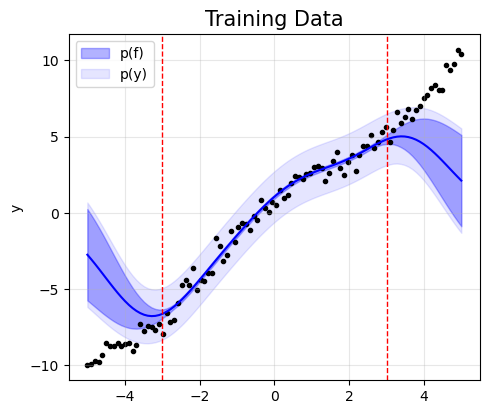

In [31]:
# Plot the model
X_test = torch.linspace(-5, 5, 100).unsqueeze(-1)
X_test = torch.cat([X_test for _ in range(P)], dim=1)
y_test = two_x_f(X_test).reshape(-1)
plot_gp_fit(gp_model['model'], gp_model['likelihood'], X_test, y_test, title='Training Data')

## 1) Covariate OOD shift point p(x)

Notice that in the offline setting where we do not get $(x_i, y_i)$ new data points online, the prior and posterior distributions are the same (after training on training dataset), since we do not observe any new data points.

In [32]:
from utils.cov_shift_tests import print_dist

# ID point x
x_test = torch.tensor([0.0] * P).unsqueeze(0)

pred = gp_model['model'](x_test)

prior_mean = pred.mean
prior_covar = torch.tensor(gp_model['model'].covar_module(x_test, x_test).numpy()).diag()

pred_mean = pred.mean
pred_covar = pred.variance

print("\n********** ID point x^* **********\n")
print_dist(x_test, prior_mean, prior_covar, pred_mean, pred_covar)


********** ID point x^* **********

Prior mean: 1.053 Predictive mean: 1.053 True value: 1.0
Prior variance: 2.831 Predictive variance: 0.004
KL divergence: 6.039
JS divergence: 3.075
Wasserstein distance: 2.827
KS statistic: 0.456


In [33]:
# OOD point x^*
x_test = torch.tensor([-5.0] * P).unsqueeze(0)
pred = gp_model['model'](x_test)

prior_mean = pred.mean
prior_covar = torch.tensor(gp_model['model'].covar_module(x_test, x_test).numpy()).diag()

pred_mean = pred.mean
pred_covar = pred.variance

print("********** OOD point x^* **********\n")
print_dist(x_test, prior_mean, prior_covar, pred_mean, pred_covar)

********** OOD point x^* **********

Prior mean: -2.745 Predictive mean: -2.745 True value: -9.716
Prior variance: 2.831 Predictive variance: 2.238
KL divergence: 0.048
JS divergence: 0.014
Wasserstein distance: 0.593
KS statistic: 0.028


In [34]:
x_s = torch.linspace(-5, 5, 100).unsqueeze(-1)


Aside from the predictive mean, which stays the same as we are not updating on any new data points, the predictive variance decreases much more for the ID point than for the OOD point. This is because the OOD point is far from the training data, and the model is not confident about its prediction.

The idea then, for an effective distance-based OOD score $S(x^*)$, to use the negative of the distance between prior and posterior predictive variances. This is because the predictive variance decreases more for OOD points than for ID points.

## 2) Train Detector and Compute the OOD score

In [58]:
from utils.cov_shift_tests import OOD_detector

# Initialize and train the OOD detector
OOD_model = OOD_detector(input_dim, model='ExactGP', lr=0.1, num_ind_pts=200)
OOD_model.train_OOD(X_train, y_train, training_iterations=50, verbose=False, K=10)

Training fold 1/10...
Training fold 2/10...
Training fold 3/10...
Training fold 4/10...
Training fold 5/10...
Training fold 6/10...
Training fold 7/10...
Training fold 8/10...
Training fold 9/10...
Training fold 10/10...


In [59]:
print(OOD_model.th_dict)

{'eucl_dist': {0.1: 6.20413875579834, 0.05: 6.464177918434143, 0.01: 6.659426474571228}, 'zscore': {0.1: 1.5989355564117431, 0.05: 1.6717921316623687, 0.01: 1.7215218365192413}, 'js_div': {0.1: 2.6597726345062256, 0.05: 2.4033799886703493, 0.01: 2.1931569814682006}, 'wass_dist': {0.1: 2.8061171054840086, 0.05: 2.8005475759506226, 0.01: 2.7939546942710876}}


### 2.1) No Overlap between ID and OOD points

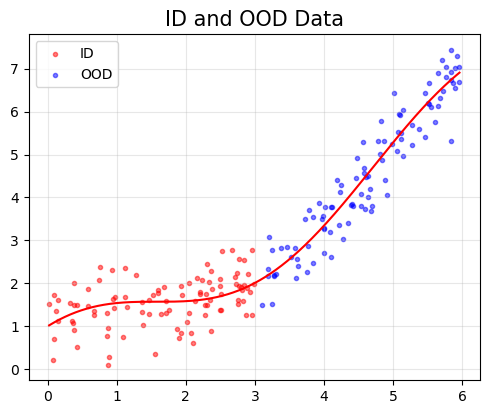

In [60]:
# 1) Test Time: we have a batch of test, of size 100, of which some are ID and some are OOD
# Generate X uniformly at random in [-5, 5]
X_test_ID = torch.rand(100, 1) * 3 - 0
X_test_OOD = torch.rand(100, 1) * 3 + 3

y_test_ID = single_x_f(X_test_ID).reshape(-1)
y_test_OOD = single_x_f(X_test_OOD).reshape(-1)

plot_ID_OOD(X_test_ID, X_test_OOD, y_test_ID, y_test_OOD, type='OOD')

In [61]:
from sklearn.metrics import roc_auc_score, confusion_matrix

# We for loop over increasingly far OOD points as standard deviations away from the mean
# Here we loop over increasing distance from the ID distribution in terms of standard deviations
ref_std = 1.0
num_std = torch.linspace(0, 4, 10)

# Metrics
auroc_ = {'Z-Score': [], 'JS Div': [], 'Wass Dist': []}
tpr_ = {'Z-Score': [], 'JS Div': [], 'Wass Dist': []}
fpr_ = {'Z-Score': [], 'JS Div': [], 'Wass Dist': []}
for i in num_std:
    
    print("\nNum std:", i.item(), "\n")
    
    X_test_ID = torch.rand(100, 1) * 3 - 0
    X_test_ID = torch.cat([X_test_ID for _ in range(P)], dim=1)
    X_test_OOD = torch.rand(100, 1) * 3 + i * ref_std
    X_test_OOD = torch.cat([X_test_OOD for _ in range(P)], dim=1)
    
    y_test_ID = two_x_f(X_test_ID).reshape(-1)
    y_test_OOD = two_x_f(X_test_OOD).reshape(-1)

    # Stack ID and OOD test data altogether
    X_test = torch.cat([X_test_ID, X_test_OOD], dim=0)
    y_test = torch.cat([y_test_ID, y_test_OOD], dim=0)
    
    # Create associated true OOD labels
    OOD_labels = torch.cat([torch.zeros(y_test_ID.size(0)), torch.ones(y_test_OOD.size(0))], dim=0)
    
    # Test the OOD detector
    OOD_pred_95 = dict()
    _, OOD_pred_95['Z-Score'], OOD_pred_95['JS Div'], OOD_pred_95['Wass Dist'] = OOD_model.predict_OOD(X_test, alpha=0.05)
    
    # Compute metrics
    for key, value in OOD_pred_95.items():
                
        # Compute confusion matrix
        cm = confusion_matrix(OOD_labels, value)
        tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])
        fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
        
        # Compute AUROC
        auroc_[key].append(roc_auc_score(OOD_labels, OOD_pred_95[key]))
        tpr_[key].append(tpr)
        fpr_[key].append(fpr)
        

    for key, value in auroc_.items():
        # print("AUROC {}: {:.4}".format(key, np.mean(value)))
        print("TPR {}: {:.4}".format(key, np.mean(tpr_[key])))
    


Num std: 0.0 

TPR Z-Score: 0.02
TPR JS Div: 0.02
TPR Wass Dist: 0.06

Num std: 0.4444444477558136 

TPR Z-Score: 0.125
TPR JS Div: 0.125
TPR Wass Dist: 0.165

Num std: 0.8888888955116272 
TPR Z-Score: 0.17
TPR JS Div: 0.17
TPR Wass Dist: 0.2267

Num std: 1.3333333730697632 

TPR Z-Score: 0.24
TPR JS Div: 0.24
TPR Wass Dist: 0.295

Num std: 1.7777777910232544 
TPR Z-Score: 0.32
TPR JS Div: 0.32
TPR Wass Dist: 0.378

Num std: 2.222222328186035 

TPR Z-Score: 0.395
TPR JS Div: 0.395
TPR Wass Dist: 0.4517

Num std: 2.6666665077209473 

TPR Z-Score: 0.4757
TPR JS Div: 0.4757
TPR Wass Dist: 0.5286

Num std: 3.1111111640930176 
TPR Z-Score: 0.5413
TPR JS Div: 0.5413
TPR Wass Dist: 0.5875

Num std: 3.555555582046509 

TPR Z-Score: 0.5922
TPR JS Div: 0.5922
TPR Wass Dist: 0.6333

Num std: 4.0 
TPR Z-Score: 0.633
TPR JS Div: 0.633
TPR Wass Dist: 0.67


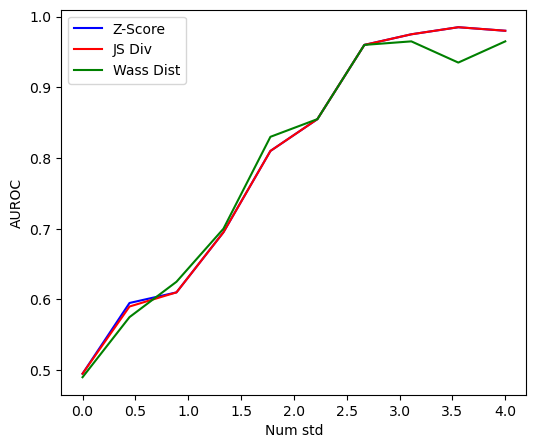

In [62]:
from matplotlib import pyplot as plt

# Plot each method's tpr (different color) vs num_std
fig = plt.figure(figsize=(6,5))

plt.subplot(1,1,1)
# Double y-axis plot, one for tpr and one for fpr
colors = ['blue', 'red', 'green', 'orange']
for key, value, colors in zip(tpr_.keys(), tpr_.values(), colors):
    plt.plot(num_std, auroc_[key], label=key, color=colors)
    plt.legend()
    plt.xlabel('Num std')
    plt.ylabel('AUROC')
    

